<a href="https://colab.research.google.com/github/Premjit1/CUSTOMER-SEGMENTATION-PYTHON/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy
import scipy.sparse
import matplotlib.pyplot as plt
import nltk
import random
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/Online Retail 11.csv'

In [ ]:
df = pd.read_csv(path,encoding="latin-1")

In [ ]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [ ]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,09-12-2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,09-12-2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,09-12-2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,09-12-2011 12:50,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,09-12-2011 12:50,4.95,12680.0,France


In [ ]:
df.shape

(541909, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [ ]:
df["Cancelled"] = df["InvoiceNo"].str.startswith("C")
df["Cancelled"] = df["Cancelled"].fillna(False)

In [ ]:
df = df[df["Description"].str.startswith("?") == False]
df = df[df["Description"].str.isupper() == True]
df = df[df["Description"].str.contains("LOST") == False]
df = df[df["CustomerID"].notnull()]
df["CustomerID"] = df["CustomerID"].astype(int)

In [ ]:
df['InvoiceNo'].replace(to_replace="\D+", value=r"", regex=True, inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('int')

In [ ]:
df = df[(df["StockCode"] != "DOT") & (df["StockCode"] != "POST")]
df.drop("StockCode", inplace=True, axis=1)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
qte_false = [74215, 3114, 80995]  # fond during exploration but not done here (found with a boxplot on qty or price)
for qte in qte_false:
    df = df[(df["Cancelled"] == False) & (df["Quantity"] !=qte)]

In [ ]:
df = df[df["Cancelled"] == False]
df.drop("Cancelled", axis=1, inplace=True)

In [ ]:
df["Price"] = df["UnitPrice"] * df["Quantity"]

In [ ]:
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 395143 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    395143 non-null  int64         
 1   Description  395143 non-null  object        
 2   Quantity     395143 non-null  int64         
 3   InvoiceDate  395143 non-null  datetime64[ns]
 4   UnitPrice    395143 non-null  float64       
 5   CustomerID   395143 non-null  int64         
 6   Country      395143 non-null  object        
 7   Price        395143 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 27.1+ MB


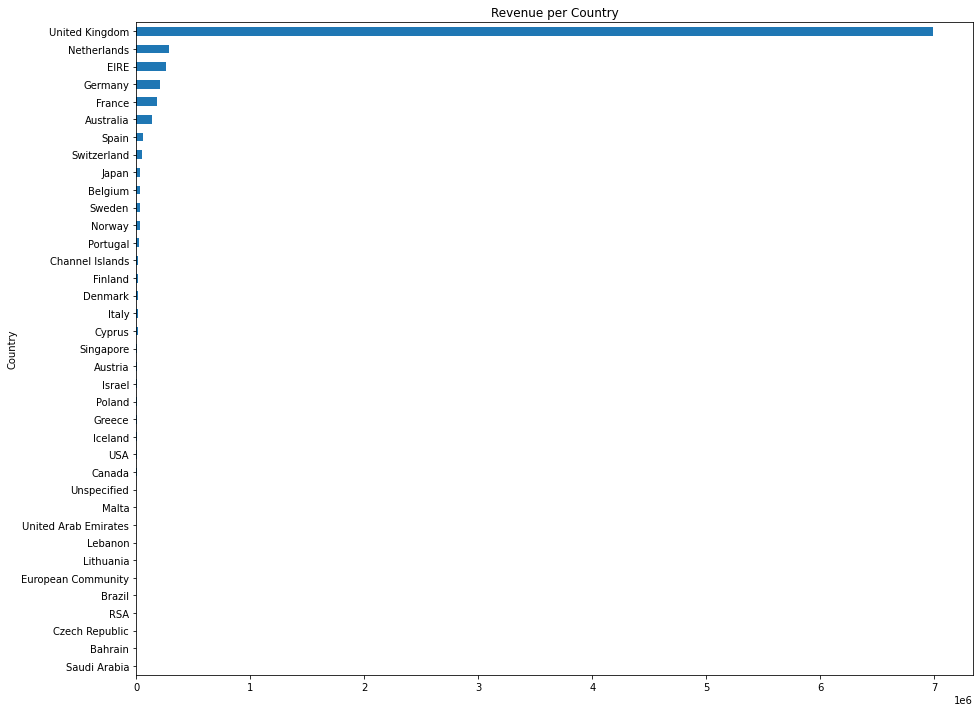

In [ ]:
revenue_per_countries = df.groupby(["Country"])["Price"].sum().sort_values()
revenue_per_countries.plot(kind='barh', figsize=(15,12))
plt.title("Revenue per Country")
plt.show()

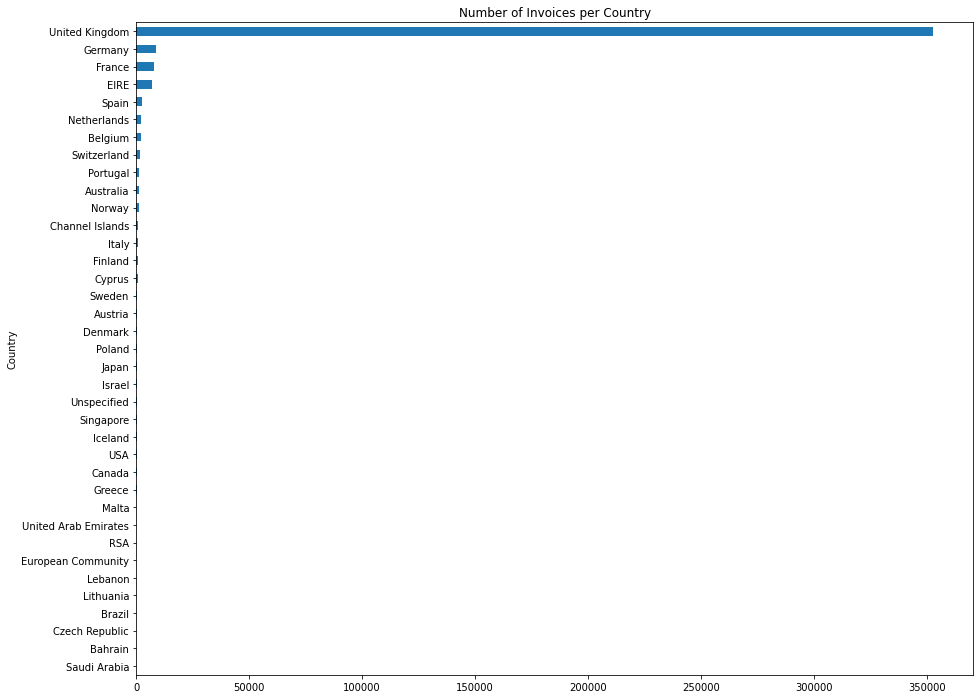

In [ ]:
No_invoice_per_country = df.groupby(["Country"])["InvoiceNo"].count().sort_values()
No_invoice_per_country.plot(kind='barh', figsize=(15,12))
plt.title("Number of Invoices per Country")
plt.show()

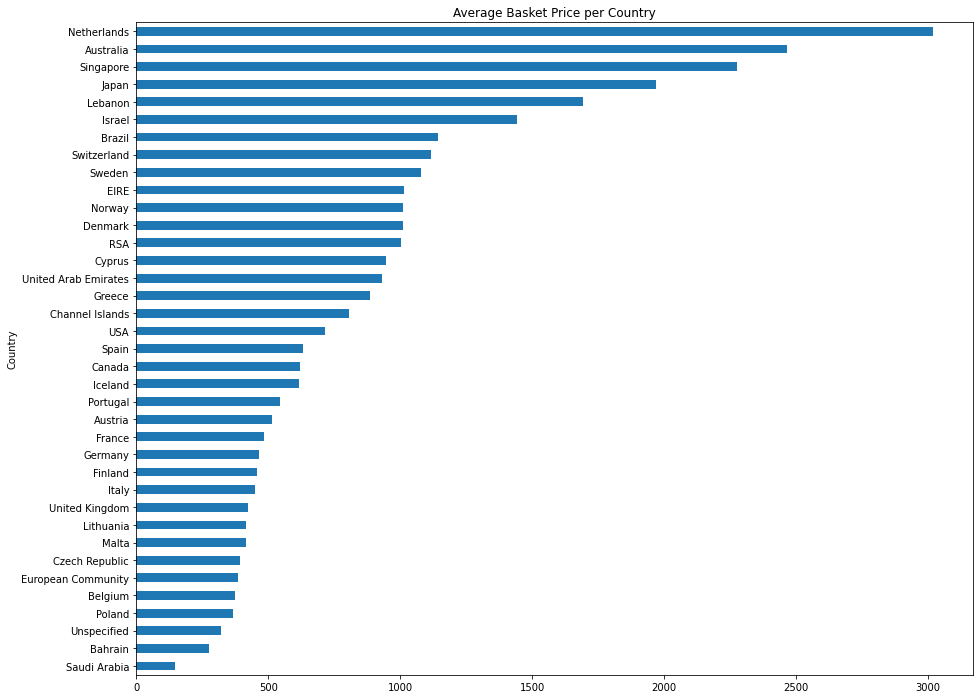

In [ ]:
best_buyer = df.groupby(["Country", "InvoiceNo"])["Price"].sum().reset_index().groupby(["Country"])["Price"].mean().sort_values()
best_buyer.plot(kind='barh', figsize=(15,12))
plt.title("Average Basket Price per Country")
plt.show()

In [ ]:
encoder_countries = best_buyer.rank().to_dict()
decoder_countries = {i: j for i, j in encoder_countries.items()}

df["Country"]  = df["Country"].apply(lambda x:encoder_countries[x])

In [ ]:
X = df["Description"].unique()

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
X = df["Description"].unique()

stemmer = nltk.stem.porter.PorterStemmer()
stopword = nltk.corpus.stopwords.words('english')

def stem_and_filter(doc):
    tokens = [stemmer.stem(w) for w in analyzer(doc)]
    return [token for token in tokens if token.isalpha()]

analyzer = CountVectorizer().build_analyzer()
CV = CountVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter)
TF_matrix = CV.fit_transform(X)
print("TF_matrix :", TF_matrix.shape, "of", TF_matrix.dtype)

analyzer = TfidfVectorizer().build_analyzer()
CV = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=stem_and_filter, min_df=0.00, max_df=0.3)  # we remove words if it appears in more than 30 % of the corpus (not found stopwords like Box, Christmas and so on)
TF_IDF_matrix = CV.fit_transform(X)
print("TF_IDF_matrix :", TF_IDF_matrix.shape, "of", TF_IDF_matrix.dtype)

TF_matrix : (3853, 1686) of int64
TF_IDF_matrix : (3853, 1686) of float64


In [ ]:
svd = TruncatedSVD(n_components = 100)
normalizer = Normalizer(copy=False)

TF_embedded = svd.fit_transform(TF_matrix)
TF_embedded = normalizer.fit_transform(TF_embedded)
print("TF_embedded :", TF_embedded.shape, "of", TF_embedded.dtype)

TF_IDF_embedded = svd.fit_transform(TF_IDF_matrix)
TF_IDF_embedded = normalizer.fit_transform(TF_IDF_embedded)
print("TF_IDF_embedded :", TF_IDF_embedded.shape, "of", TF_IDF_embedded.dtype)

TF_embedded : (3853, 100) of float64
TF_IDF_embedded : (3853, 100) of float64


In [ ]:
score_tf = []
score_tfidf = []
mean_tf = []
std_tf = []
mean_tfidf = []
std_tfidf = []

x = list(range(5, 105, 5))

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_embedded)
    clusters = kmeans.predict(TF_embedded)
    silhouette_avg = silhouette_score(TF_embedded, clusters)
#     print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)
    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tf.append(silhouette_avg)
    mean_tf.append(rep.mean())
    std_tf.append(rep.std())

for n_clusters in x:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(TF_IDF_embedded)
    clusters = kmeans.predict(TF_IDF_embedded)
    silhouette_avg = silhouette_score(TF_IDF_embedded, clusters)
#     print("N clusters =", n_clusters, "Silhouette Score :", silhouette_avg)
    rep = np.histogram(clusters, bins = n_clusters-1)[0]
    score_tfidf.append(silhouette_avg)
    mean_tfidf.append(rep.mean())
    std_tfidf.append(rep.std())

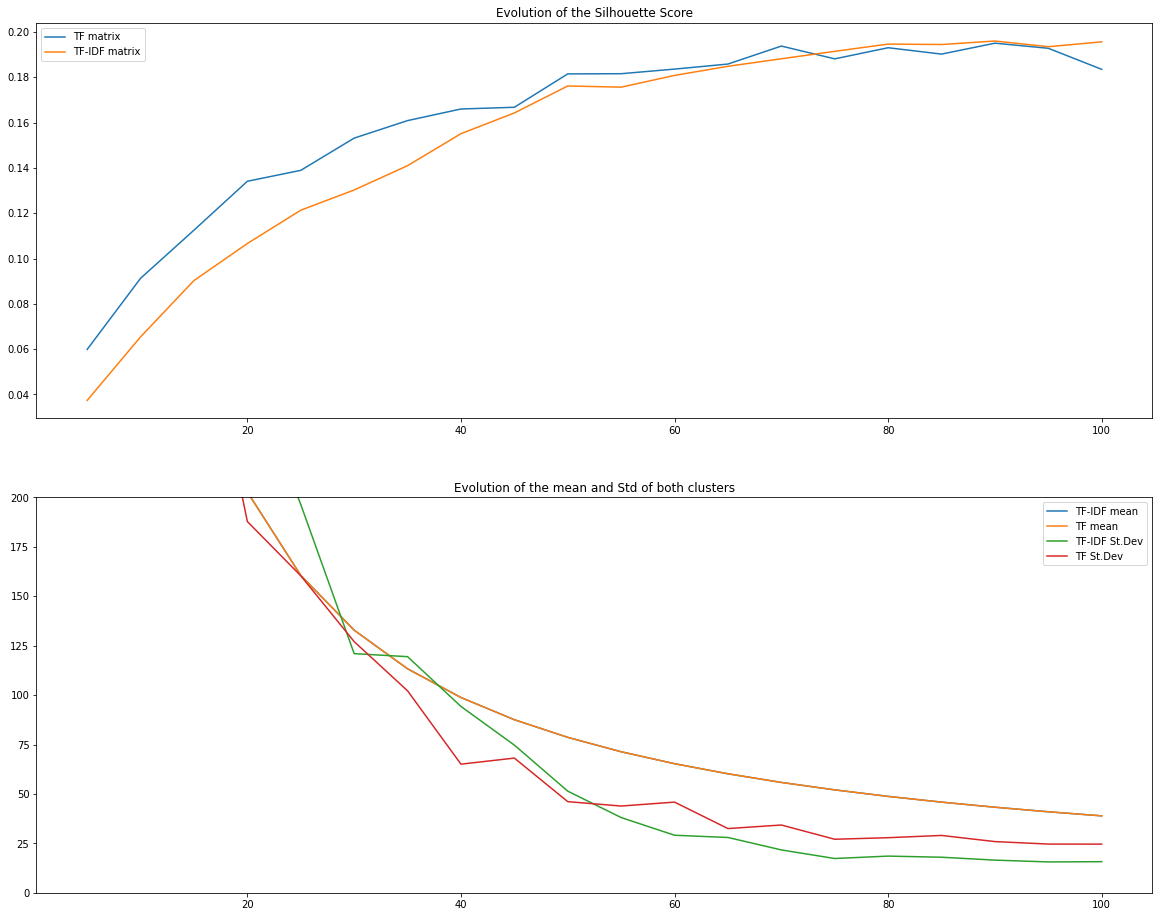

In [ ]:
plt.figure(figsize=(20,16))

plt.subplot(2, 1, 1)
plt.plot(x, score_tf, label="TF matrix")
plt.plot(x, score_tfidf, label="TF-IDF matrix")
plt.title("Evolution of the Silhouette Score")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(x, mean_tfidf, label="TF-IDF mean")
plt.plot(x, mean_tf, label="TF mean")
plt.plot(x, std_tfidf, label="TF-IDF St.Dev")
plt.plot(x, std_tf, label="TF St.Dev")
plt.ylim(0, 200)
plt.title("Evolution of the mean and Std of both clusters")
plt.legend()

plt.show()

In [ ]:
n_clusters = 100

kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30, random_state=42)
kmeans.fit(TF_IDF_embedded)
clusters = kmeans.predict(TF_IDF_embedded)

In [ ]:
plt.figure(figsize=(20,8))
wc = WordCloud()


<Figure size 1440x576 with 0 Axes>

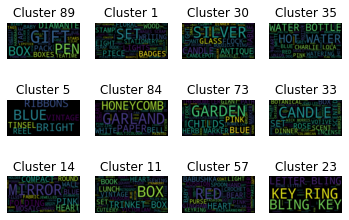

<Figure size 432x288 with 0 Axes>

In [ ]:
for num, cluster in enumerate(random.sample(range(100), 12)) :
    plt.subplot(3, 4, num+1)
    wc.generate(" ".join(X[np.where(clusters==cluster)]))
    plt.imshow(wc, interpolation='bilinear')
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()
plt.show()

In [ ]:
dict_article_to_cluster = {article : cluster for article, cluster in zip(X, clusters)}

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


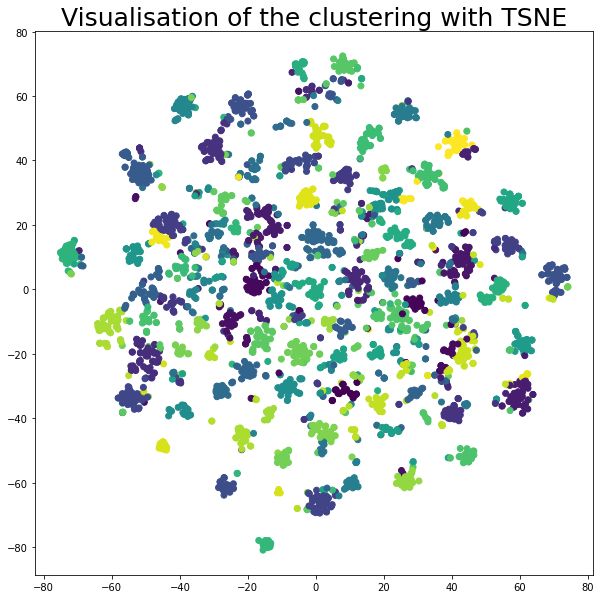

In [ ]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(TF_IDF_embedded)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualisation of the clustering with TSNE", fontsize="25")
plt.show()

In [ ]:
cluster = df['Description'].apply(lambda x : dict_article_to_cluster[x])
df2 = pd.get_dummies(cluster, prefix="Article_cluster").mul(df["Price"], 0)
df2 = pd.concat([df['InvoiceNo'], df2], axis=1)
df2_grouped = df2.groupby('InvoiceNo').sum()

In [ ]:
custom_aggregation = {}
custom_aggregation["Price"] = "sum"
custom_aggregation["InvoiceDate"] = lambda x:x.iloc[0]
custom_aggregation["CustomerID"] = lambda x:x.iloc[0]
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"

df_grouped = df.groupby("InvoiceNo").agg(custom_aggregation)

In [ ]:
now = df_grouped["InvoiceDate"].max()  # as the dataset is not done in the present
df_grouped["Recency"] = now - df_grouped["InvoiceDate"]
df_grouped["Recency"] = pd.to_timedelta(df_grouped["Recency"]).astype("timedelta64[D]") # conversion to day from now

# add features required for the next groupby
df_grouped["nb_visit"] = 1
df_grouped["total_spent"] = 1

In [ ]:
df2_grouped_final = pd.concat([df_grouped['CustomerID'], df2_grouped], axis=1).set_index("CustomerID").groupby("CustomerID").sum()
df2_grouped_final = df2_grouped_final.div(df2_grouped_final.sum(axis=1), axis=0)
df2_grouped_final = df2_grouped_final.fillna(0)

In [ ]:
custom_aggregation = {}
custom_aggregation["Price"] = ["mean", "sum"]
custom_aggregation["nb_visit"] = "sum"
custom_aggregation["Country"] = lambda x:x.iloc[0]
custom_aggregation["Quantity"] = "sum"
custom_aggregation["Recency"] = ["min", "max"]

df_grouped_final = df_grouped.groupby("CustomerID").agg(custom_aggregation)

In [ ]:
df_grouped_final["Freq"] = (df_grouped_final["Recency"]["max"]  - df_grouped_final["Recency"]["min"] ) / df_grouped_final["nb_visit"]["sum"]
df_grouped_final.columns = ["avg_price", "sum_price", "nb_visit", "country", "quantity", "min_recency", "max_recency", "freq"]

In [ ]:
df_grouped_final.head()

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq
CustomerID,,,,,,,,
12347,615.714286,4310.00,7,17.0,2458,40.0,516.0,68.000000
12348,359.310000,1437.24,4,12.0,2332,76.0,358.0,70.500000
12349,1457.550000,1457.55,1,11.0,630,19.0,19.0,0.000000
12350,294.400000,294.40,1,27.0,196,311.0,311.0,0.000000
12352,197.962857,1385.74,7,27.0,526,73.0,341.0,38.285714


In [ ]:
X1 = df_grouped_final.values 
X2 = df2_grouped_final.values

scaler = StandardScaler()
X1 = scaler.fit_transform(X1)
X_final_std_scale = np.concatenate((X1, X2), axis=1)

scaler = MinMaxScaler()
X1 = scaler.fit_transform(X1)
X_final_minmax_scale = np.concatenate((X1, X2), axis=1)

In [ ]:
x = list(range(2, 10))
y_std = []
y_minmax = []
for n_clusters in x:
    print("n_clusters =", n_clusters)
    
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=10)
    kmeans.fit(X_final_std_scale)
    clusters = kmeans.predict(X_final_std_scale)
    silhouette_avg = silhouette_score(X_final_std_scale, clusters)
    y_std.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with Std Scaling")
    
    kmeans.fit(X_final_minmax_scale)
    clusters = kmeans.predict(X_final_minmax_scale)
    silhouette_avg = silhouette_score(X_final_minmax_scale, clusters)
    y_minmax.append(silhouette_avg)
    print("The average silhouette_score is :", silhouette_avg, "with MinMax Scaling")

n_clusters = 2
The average silhouette_score is : 0.8997570649244768 with Std Scaling
The average silhouette_score is : 0.13288146627592778 with MinMax Scaling
n_clusters = 3
The average silhouette_score is : 0.2553745588410631 with Std Scaling
The average silhouette_score is : 0.14775219106008936 with MinMax Scaling
n_clusters = 4
The average silhouette_score is : 0.27371596148946475 with Std Scaling
The average silhouette_score is : 0.11715146487527711 with MinMax Scaling
n_clusters = 5
The average silhouette_score is : 0.2712388358161171 with Std Scaling
The average silhouette_score is : 0.12532817949366734 with MinMax Scaling
n_clusters = 6
The average silhouette_score is : 0.281688606038578 with Std Scaling
The average silhouette_score is : 0.1292791269986554 with MinMax Scaling
n_clusters = 7
The average silhouette_score is : 0.28872607557964614 with Std Scaling
The average silhouette_score is : 0.13108378824511285 with MinMax Scaling
n_clusters = 8
The average silhouette_score is

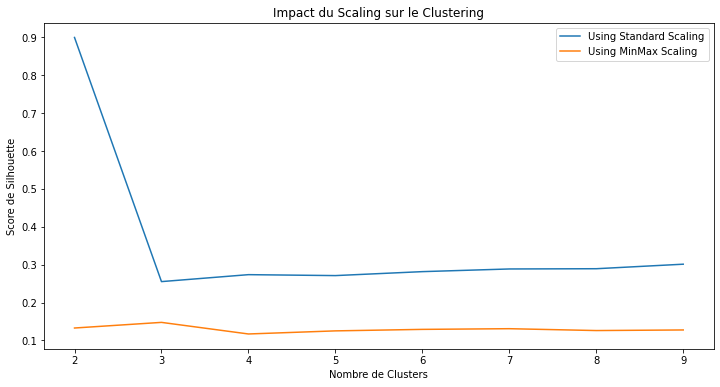

In [ ]:
plt.figure(figsize=(12,6))

plt.plot(x, y_std, label="Using Standard Scaling")
plt.plot(x, y_minmax, label="Using MinMax Scaling")

plt.legend()
plt.xlabel("Nombre de Clusters")
plt.ylabel("Score de Silhouette")
plt.title("Impact du Scaling sur le Clustering")
plt.xticks(x)

plt.show()

In [ ]:
kmeans = KMeans(init='k-means++', n_clusters = 6, n_init=30, random_state=42)  # random state just to be able to provide cluster number durint analysis
kmeans.fit(X_final_std_scale)
clusters = kmeans.predict(X_final_std_scale)

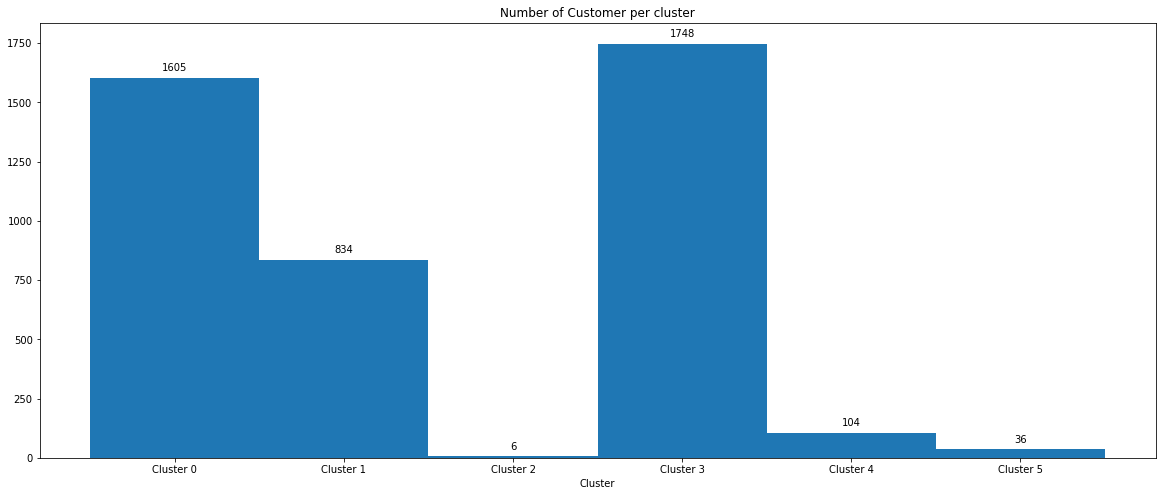

In [ ]:
plt.figure(figsize = (20,8))
n, bins, patches = plt.hist(clusters, bins=6) # arguments are passed to np.histogram
plt.xlabel("Cluster")
plt.title("Number of Customer per cluster")
plt.xticks([rect.get_x()+ rect.get_width() / 2 for rect in patches], ["Cluster {}".format(x) for x in range(6)])

for rect in patches:
    y_value = rect.get_height()
    x_value = rect.get_x() + rect.get_width() / 2

    space = 5
    va = 'bottom'
    label = str(int(y_value))
    
    plt.annotate(
        label,                      # Use `label` as label
        (x_value, y_value),         # Place label at end of the bar
        xytext=(0, space),          # Vertically shift label by `space`
        textcoords="offset points", # Interpret `xytext` as offset in points
        ha='center',                # Horizontally center label
        va=va)                      # Vertically align label differently for
                                    # positive and negative values.

plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


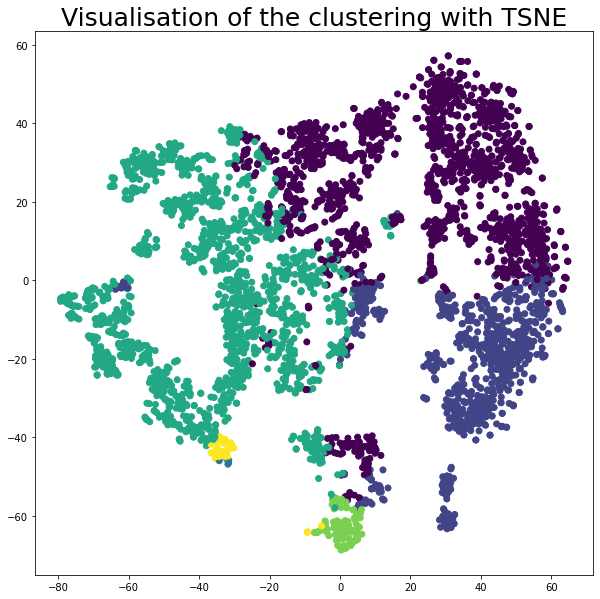

In [ ]:
tsne = TSNE(n_components=2)
proj = tsne.fit_transform(X_final_std_scale)

plt.figure(figsize=(10,10))
plt.scatter(proj[:,0], proj[:,1], c=clusters)
plt.title("Visualisation of the clustering with TSNE", fontsize="25")
plt.show()

In [ ]:
df_grouped_final["cluster"] = clusters
df_grouped_final.head()

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq,cluster
CustomerID,,,,,,,,,
12347,615.714286,4310.00,7,17.0,2458,40.0,516.0,68.000000,3
12348,359.310000,1437.24,4,12.0,2332,76.0,358.0,70.500000,3
12349,1457.550000,1457.55,1,11.0,630,19.0,19.0,0.000000,0
12350,294.400000,294.40,1,27.0,196,311.0,311.0,0.000000,4
12352,197.962857,1385.74,7,27.0,526,73.0,341.0,38.285714,4


In [ ]:
df_analysis = df_grouped_final.groupby("cluster").mean()
df_analysis.head()

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq
cluster,,,,,,,,
0,349.320813,705.834064,2.051713,10.209969,455.124611,69.830530,112.579439,13.230685
1,300.965722,440.511968,1.486811,10.245803,255.011990,291.675060,310.267386,6.962084
2,3574.186403,185895.701667,75.500000,24.833333,91219.666667,7.000000,509.500000,9.165050
3,357.450294,2406.247111,6.590389,10.198513,1413.021167,51.213959,374.469680,71.428615
4,1008.990188,2470.497885,2.682692,28.567308,1343.836538,117.961538,249.125000,35.910371


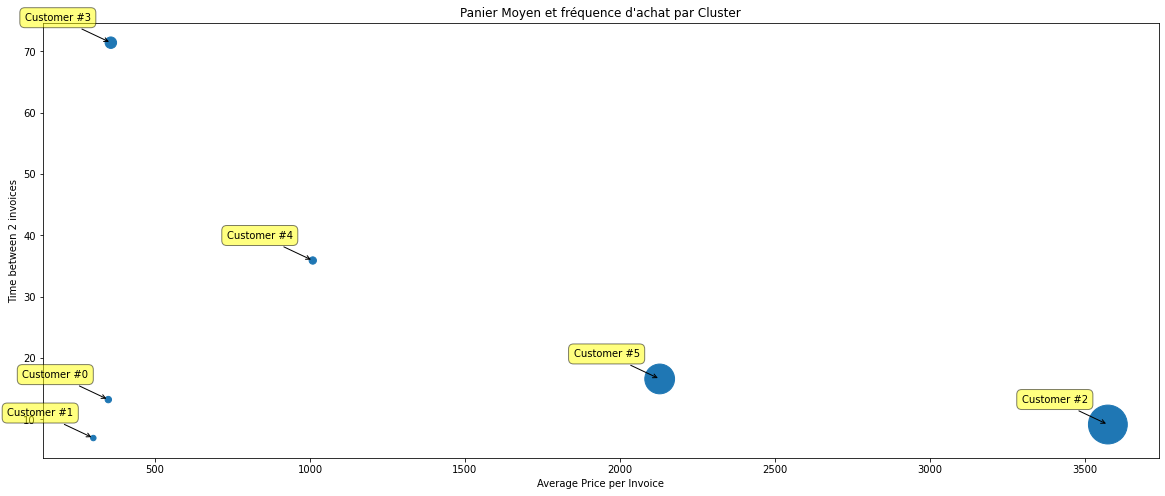

In [ ]:
price = df_analysis["avg_price"].values
freq = df_analysis["freq"].values
visit = df_analysis["nb_visit"].values

plt.figure(figsize = (20,8))
plt.scatter(price, freq, s=visit*20)
    
for label, x, y in zip(["Customer #{}".format(x) for x in range(6)], price, freq):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-20, 20),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
plt.title("Panier Moyen et fréquence d'achat par Cluster")
plt.xlabel("Average Price per Invoice")
plt.ylabel("Time between 2 invoices")

plt.show()

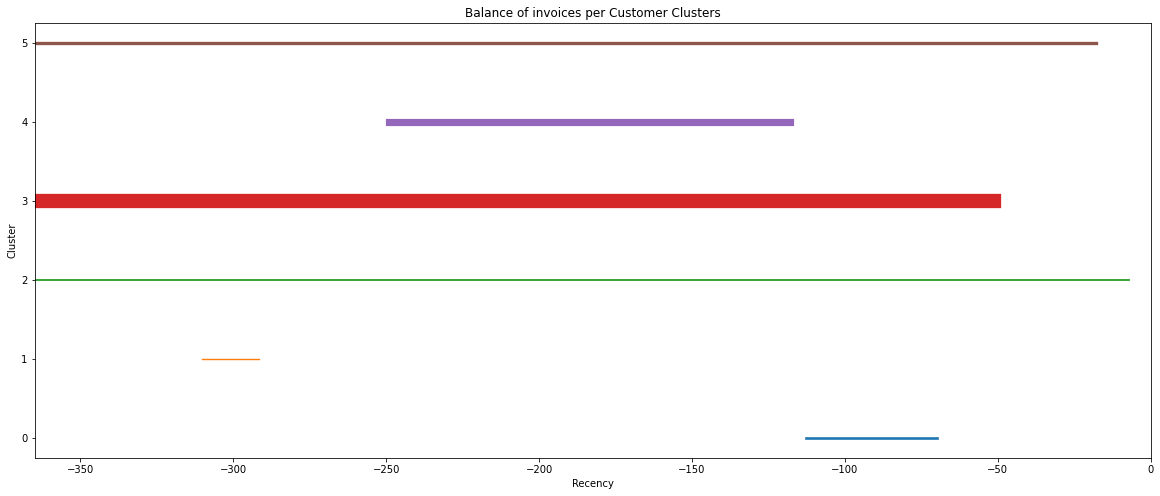

In [ ]:
x_max = df_analysis["min_recency"].values
x_min = df_analysis["max_recency"].values
freq = df_analysis["freq"].values

plt.figure(figsize = (20,8))
for i in range(6):
    plt.plot([-x_min[i] , -x_max[i]], [i, i], linewidth=freq[i]/5)

plt.xlim(-365, 0)
plt.title("Balance of invoices per Customer Clusters")
plt.xlabel("Recency")
plt.ylabel("Cluster")
plt.show()

In [ ]:
purchase_mean = df2_grouped_final.set_index(clusters).groupby(clusters).mean()
purchase_mean.head()

,Article_cluster_0,Article_cluster_1,Article_cluster_2,Article_cluster_3,Article_cluster_4,Article_cluster_5,Article_cluster_6,Article_cluster_7,Article_cluster_8,Article_cluster_9,...,Article_cluster_90,Article_cluster_91,Article_cluster_92,Article_cluster_93,Article_cluster_94,Article_cluster_95,Article_cluster_96,Article_cluster_97,Article_cluster_98,Article_cluster_99
0,0.002544,0.011265,0.007646,0.014134,0.012609,0.000015,0.035324,0.015187,0.011739,0.003806,...,0.012333,0.039724,0.009307,0.004185,0.021097,0.006953,0.009858,0.021785,0.000928,0.007028
1,0.001706,0.011971,0.003977,0.010312,0.015863,0.000090,0.040731,0.016666,0.008641,0.003614,...,0.012213,0.034274,0.013027,0.007252,0.027674,0.004701,0.009154,0.031513,0.001278,0.008354
2,0.000798,0.011463,0.001191,0.007399,0.014499,0.000036,0.041674,0.004940,0.004880,0.003465,...,0.019411,0.027904,0.018336,0.018969,0.024577,0.006888,0.010681,0.026133,0.000605,0.006845
3,0.002161,0.010788,0.004199,0.015500,0.015765,0.000126,0.044701,0.013092,0.010568,0.003358,...,0.011918,0.047434,0.010404,0.005541,0.021413,0.006496,0.008378,0.025869,0.001709,0.006985
4,0.001472,0.012598,0.001494,0.010319,0.008981,0.000064,0.054035,0.011137,0.006039,0.001366,...,0.010118,0.049427,0.005467,0.007476,0.026305,0.013931,0.019772,0.011640,0.000413,0.005463


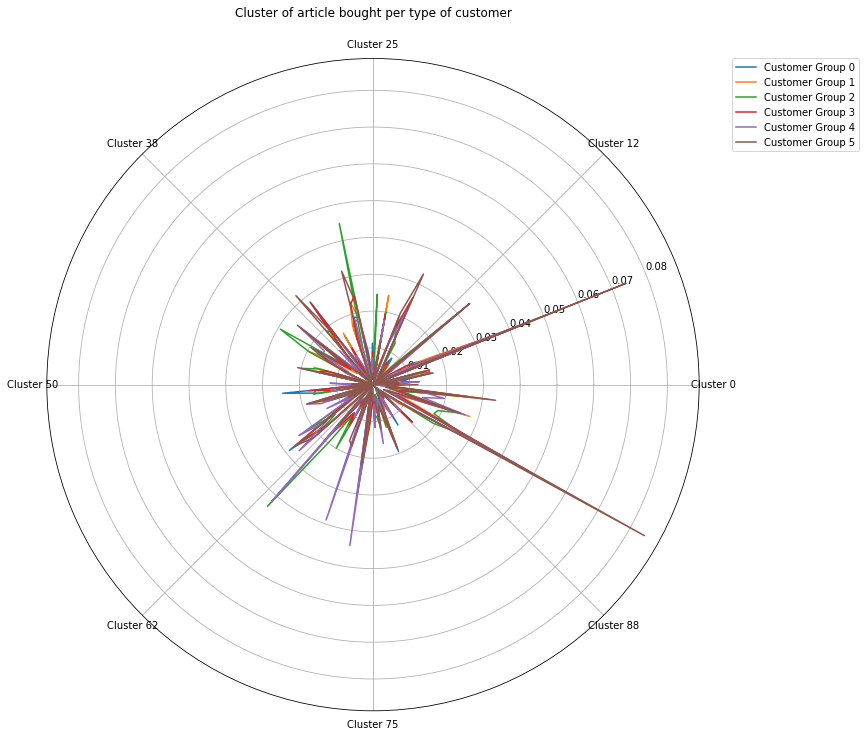

In [ ]:
plt.figure(figsize=(15,12))
ax = plt.subplot(111, projection='polar')
theta = 2 * np.pi * np.linspace(0, 1, 100)
matrix = purchase_mean.values

for i in range(6):
    r = matrix[i, :]
    ax.plot(theta, r, label="Customer Group {}".format(i))

ax.set_xticklabels([
    "Cluster 0", "Cluster 12", "Cluster 25", "Cluster 38", 
    "Cluster 50", "Cluster 62", "Cluster 75", "Cluster 88"
])

ax.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title("Cluster of article bought per type of customer", va='bottom')
plt.show()

In [ ]:
clusters.shape

(4333,)

In [ ]:
classification_dataset = pd.concat([df_grouped_final, df2_grouped_final], axis = 1)
classification_dataset.head()

,avg_price,sum_price,nb_visit,country,quantity,min_recency,max_recency,freq,cluster,Article_cluster_0,...,Article_cluster_90,Article_cluster_91,Article_cluster_92,Article_cluster_93,Article_cluster_94,Article_cluster_95,Article_cluster_96,Article_cluster_97,Article_cluster_98,Article_cluster_99
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,615.714286,4310.00,7,17.0,2458,40.0,516.0,68.000000,3,0.002088,...,0.046775,0.012831,0.000000,0.004733,0.044374,0.000000,0.000000,0.000000,0.0,0.000000
12348,359.310000,1437.24,4,12.0,2332,76.0,358.0,70.500000,3,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
12349,1457.550000,1457.55,1,11.0,630,19.0,19.0,0.000000,0,0.000000,...,0.000000,0.000000,0.032417,0.000000,0.008748,0.000000,0.000000,0.010291,0.0,0.026963
12350,294.400000,294.40,1,27.0,196,311.0,311.0,0.000000,4,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
12352,197.962857,1385.74,7,27.0,526,73.0,341.0,38.285714,4,0.000000,...,0.000000,0.000000,0.053906,0.000000,0.046004,0.010716,0.025077,0.008443,0.0,0.000000


In [ ]:
X = classification_dataset.drop("cluster", axis=1).values
y = classification_dataset["cluster"].values

In [ ]:
min_samples_split = 4 
cv = 5
n_estimators = 40

In [ ]:
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
for max_depth in range(3, 10):
    clf = DecisionTreeClassifier(random_state=0, max_depth=max_depth, min_samples_split=min_samples_split )
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=5, n_jobs=8)
    scores = np.array(scores)
    print("Depth {} : Acc {:.3f} - Dev {:.3f}".format(max_depth, scores.mean(), scores.std()))

Depth 3 : Acc 0.931 - Dev 0.012
Depth 4 : Acc 0.953 - Dev 0.009
Depth 5 : Acc 0.956 - Dev 0.008
Depth 6 : Acc 0.958 - Dev 0.011
Depth 7 : Acc 0.964 - Dev 0.009
Depth 8 : Acc 0.963 - Dev 0.010
Depth 9 : Acc 0.963 - Dev 0.008


In [ ]:
for max_depth in range(3, 10):
    clf = ExtraTreeClassifier(random_state=0, max_depth=max_depth, min_samples_split=min_samples_split )
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=cv, n_jobs=8)
    scores = np.array(scores)
    print("Depth {} : Acc {:.3f} - Dev {:.3f}".format(max_depth, scores.mean(), scores.std()))

Depth 3 : Acc 0.578 - Dev 0.004
Depth 4 : Acc 0.573 - Dev 0.007
Depth 5 : Acc 0.623 - Dev 0.020
Depth 6 : Acc 0.627 - Dev 0.025
Depth 7 : Acc 0.627 - Dev 0.019
Depth 8 : Acc 0.640 - Dev 0.012
Depth 9 : Acc 0.674 - Dev 0.054


In [ ]:
for max_depth in range(3, 10):
    clf = RandomForestClassifier(n_estimators=n_estimators, random_state=0, max_depth=max_depth, min_samples_split=min_samples_split )
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=cv, n_jobs=8)
    scores = np.array(scores)
    print("Depth {} : Acc {:.3f} - Dev {:.3f}".format(max_depth, scores.mean(), scores.std()))

Depth 3 : Acc 0.862 - Dev 0.007
Depth 4 : Acc 0.894 - Dev 0.010
Depth 5 : Acc 0.908 - Dev 0.011
Depth 6 : Acc 0.916 - Dev 0.011
Depth 7 : Acc 0.919 - Dev 0.008
Depth 8 : Acc 0.932 - Dev 0.012
Depth 9 : Acc 0.937 - Dev 0.009


In [ ]:
for max_depth in range(3, 10):
    clf = ExtraTreesClassifier(n_estimators=n_estimators, random_state=0, max_depth=max_depth, min_samples_split=min_samples_split )
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=cv, n_jobs=8)
    scores = np.array(scores)
    print("Depth {} : Acc {:.3f} - Dev {:.3f}".format(max_depth, scores.mean(), scores.std()))

Depth 3 : Acc 0.735 - Dev 0.008
Depth 4 : Acc 0.744 - Dev 0.010
Depth 5 : Acc 0.788 - Dev 0.017
Depth 6 : Acc 0.837 - Dev 0.012
Depth 7 : Acc 0.839 - Dev 0.016
Depth 8 : Acc 0.856 - Dev 0.010
Depth 9 : Acc 0.875 - Dev 0.012


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

clf1 = DecisionTreeClassifier(random_state=0, max_depth=9, min_samples_split=4 )
clf2 = RandomForestClassifier(random_state=0, max_depth=9, min_samples_split=4, n_estimators=n_estimators)

clf1.fit(X_train, y_train)
clf2.fit(X_train, y_train)

y_pred1 = clf1.predict(X_test)
y_pred2 = clf2.predict(X_test)

In [ ]:
np.unique(y_pred1)

array([0, 1, 2, 3, 4, 5], dtype=int32)

Confusion matrix, without normalization
Confusion matrix, without normalization


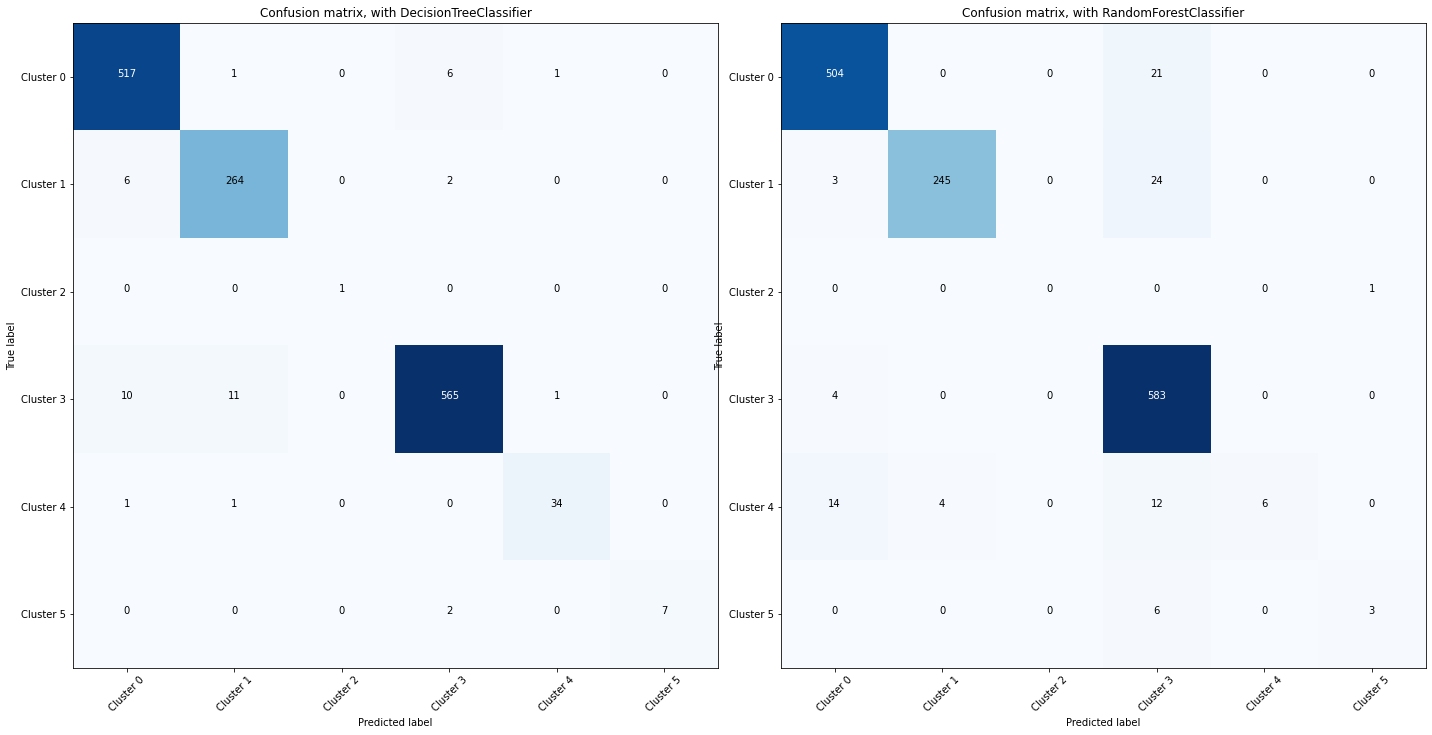

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

classes = ["Cluster {}".format(x) for x in range(6)]
np.set_printoptions(precision=2)

plt.figure(figsize=(20,12))
plt.subplot(1, 2, 1)
cnf_matrix = confusion_matrix(y_test, y_pred1)
plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix, with DecisionTreeClassifier')

plt.subplot(1, 2, 2)
cnf_matrix = confusion_matrix(y_test, y_pred2)
plot_confusion_matrix(cnf_matrix, classes=classes, title='Confusion matrix, with RandomForestClassifier')

plt.show()